In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import h5py
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from GNN.utils.datautils import  get_data
from scipy.optimize import curve_fit
from sklearn.metrics import confusion_matrix
from GNN.utils.cm import plot_confusion_matrix
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.mock_observables import tpcf
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
import pandas as pd
import pickle
import seaborn as sns
sns.set_context('talk')

Using TensorFlow backend.


In [2]:
output_file = 'merged_dataframe.h5'
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'
 
train, test = get_data(data_path + output_file, arg_label = 'both')

In [6]:
train.head()

,ID_DMO,ID_HYDRO,M200_DMO,M200_HYDRO,M200c,Vmax_x,Rmax,R200c,Cnfw,Rhosnfw,...,vpeak,N_subhalos,VelDisp,Vmax_y,Spin,fsub_unbound,x_offset,N_gals,M_stars,labels
131073,225031,240522,1.099000e+11,9.548000e+10,1.098593e+11,96.036136,0.008820,77.896492,7.866057,6.573355e+06,...,109.120918,2.0,50.795364,96.371979,16.453821,0.023512,1936.219399,0.0,3.390875e+08,False
2,7238,5392,2.402000e+12,2.440000e+12,2.402108e+12,231.512614,0.352976,217.811813,3.177258,7.646312e+05,...,179.030655,68.0,106.490150,172.920883,17.734689,0.698938,529.864573,8.0,1.215231e+11,True
131074,211548,240523,1.197000e+11,1.006000e+11,1.197391e+11,101.082098,0.014888,80.161522,11.203557,1.596397e+07,...,125.309128,1.0,53.648438,100.854340,17.963010,0.001028,604.320757,0.0,3.599013e+08,False
4,5543,6160,6.915000e+12,5.426000e+12,6.914848e+12,355.372052,0.085405,309.844360,8.628157,8.548512e+06,...,387.690948,42.0,202.599243,354.689484,13.767239,0.024623,515.772693,3.0,1.768937e+11,True
5,7681,6173,3.631000e+12,3.173000e+12,3.630934e+12,253.125835,0.200317,249.969940,3.840995,1.224789e+06,...,238.246887,72.0,147.766602,229.021530,27.157521,0.276874,367.230657,8.0,1.258065e+11,True


In [25]:
a = list(train.columns)

In [26]:
a.remove('ID_DMO') if 'ID_DMO' in a else None

In [27]:
a

['ID_HYDRO',
 'M200_DMO',
 'M200_HYDRO',
 'M200c',
 'Vmax_x',
 'Rmax',
 'R200c',
 'Cnfw',
 'Rhosnfw',
 'Formation Time',
 'Nmergers',
 'MassPeak',
 'vpeak',
 'N_subhalos',
 'VelDisp',
 'Vmax_y',
 'Spin',
 'fsub_unbound',
 'x_offset',
 'N_gals',
 'M_stars',
 'labels']

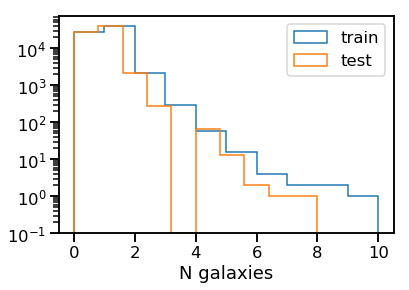

In [5]:
plt.hist(train.N_gals, log=True, histtype='step', label = 'train')
plt.hist(test.N_gals, log=True, histtype='step', label = 'test')
plt.xlabel('N galaxies')
plt.legend()

In [6]:
bins = np.logspace(np.log10(0.01), np.log10(800), 20)

Text(0.5,0,'$M_{200c}$')

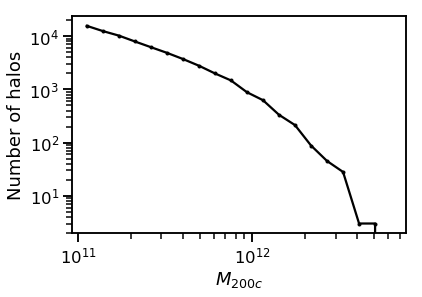

In [7]:
nbins= 20
bins = np.logspace(np.log10(np.min(train.M200c)),
                   np.log10(np.max(train.M200c)), nbins+1)

bin_centers = (bins[1:]+bins[:-1])/2.

mass_func, edges = np.histogram(train.M200c, bins=bins)
plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='black', marker='o',markersize=3)

plt.ylabel('Number of halos')
plt.xlabel(r'$M_{200c}$')

# Fit HOD parameters to training set

In [8]:
n_centrals = train.labels
n_satellites = train.N_gals - 1

In [9]:
n_centrals_binned, edges, _ = binned_statistic(train.M200c, n_centrals, statistic = 'mean',
                                     bins=bins)

n_centrals_error, edges, _ = binned_statistic(train.M200c, n_centrals, statistic = 'std',
                                     bins=bins)

In [10]:
n_satellites_binned, edges, _ = binned_statistic(train.M200c, n_satellites, statistic = 'mean',
                                     bins=bins)

n_satellites_error, edges, _ = binned_statistic(train.M200c, n_satellites, statistic = 'std',
                                     bins=bins)

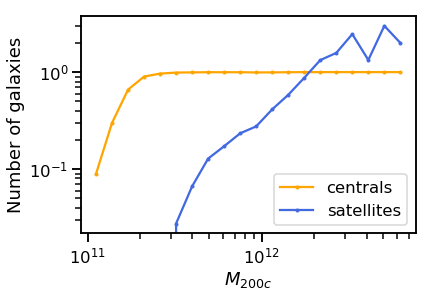

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

## Find HOD parameters

In [12]:
cen_model = Zheng07Cens()

def mean_centrals(mass, logMin, sigma_logM):

    cen_model.param_dict = {'logMmin': logMin,
                    'sigma_logM': sigma_logM}
    
    return cen_model.mean_occupation(prim_haloprop = mass)

sats_model = Zheng07Sats()

def mean_sats(mass, M0, M1, alpha):
    
    logM0 = np.log10(M0)

    logM1 = np.log10(M1)
    
    sats_model.param_dict = {'logM0': logM0, 
                'logM1': logM1, 'alpha': alpha}
    
    return sats_model.mean_occupation(prim_haloprop = mass)
    


In [13]:
popt_central, pcov_central = curve_fit(mean_centrals, bin_centers,
                      n_centrals_binned,
                    p0 = list(cen_model.param_dict.values()))

In [14]:
popt_sats, pcov_sats = curve_fit(mean_sats, bin_centers,
                      n_satellites_binned,
                    p0 =list(sats_model.param_dict.values()))

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [15]:
nbins= 30
masses = np.logspace(np.log10(np.min(train.M200c)),
                   np.log10(np.max(train.M200c)), nbins+1)

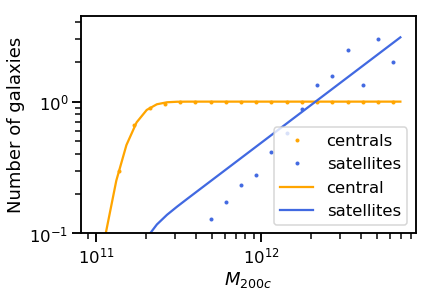

In [16]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals', linestyle='')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites', linestyle='')

cen_model.param_dict = {'logMmin':popt_central[0], 'sigma_logM': popt_central[1]}

sats_model.param_dict = {'logM0': np.log10(popt_sats[0]), 
                'logM1': np.log10(popt_sats[1]), 'alpha': popt_sats[2]}
ax.plot(masses,
           cen_model.mean_occupation(prim_haloprop = masses), #yerr = n_satellites_error, 
             color='orange',
        label = 'central')

ax.plot(masses,
          cen_model.mean_occupation(prim_haloprop = masses)*  sats_model.mean_occupation(prim_haloprop = masses) , #yerr = n_satellites_error, 
             color='royalblue',
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.ylim(1e-1)
plt.legend()

# Performance on test set

In [17]:
np.random.seed(22222)

Udf = np.random.uniform(0,1,len(test))

N_mean_cen = cen_model.mean_occupation(prim_haloprop = test.M200c)



In [18]:
Nc_test = (N_mean_cen > Udf).astype(int)

In [20]:
cm = confusion_matrix(test.labels, Nc_test)

Normalized confusion matrix


(array([[0.75550952, 0.24449048],
        [0.16702115, 0.83297885]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2ae263a21860>)

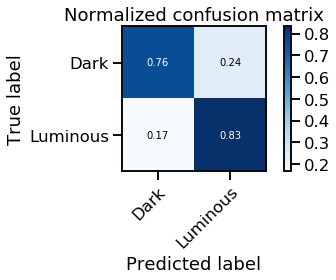

In [22]:
plot_confusion_matrix(test.labels,
    Nc_test, classes = ['Dark', 'Luminous'], 
    normalize = True)

## Two point correlation function for the test set central galaxies

In [25]:
pos_test = positions[test_idx, :].clip(0.)

pos_test_galaxies = pos_test[labels[test_idx] > 0]

r = np.geomspace(0.3, 30., 50)

test_tpcf = tpcf(pos_test_galaxies, rbins = r, period = boxsize, estimator =  'Landy-Szalay' )

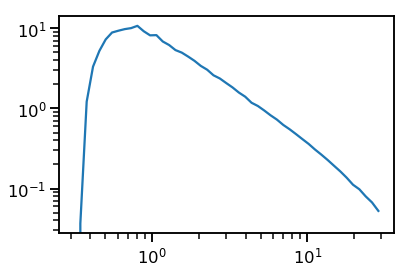

In [26]:
r_c = 0.5 * (r[1:] + r[:-1])
plt.loglog(r_c, test_tpcf)

## Populate halo catalog

In [27]:
halocat = UserSuppliedHaloCatalog( redshift = 0., Lbox = boxsize, 
        halo_x = positions[:, 0].clip(0), halo_y = positions[:, 1], halo_z = positions[:, 2],
        halo_vx = velocities[:,0], halo_vy = velocities[:,1], halo_vz = velocities[:,2],
        halo_mvir = mass, halo_id = np.arange(mass.shape[0]), halo_hostid = np.arange(mass.shape[0]),
        particle_mass = 1e9, halo_upid = -1. * np.ones_like(mass),
        halo_rvir = rvir
        )

In [28]:
cens_prof_model = TrivialPhaseSpace()

In [29]:
#sats_prof_model = TrivialPhaseSpace()

In [30]:
model_instance = HodModelFactory(
    centrals_occupation = cen_model,
    centrals_profile = cens_prof_model)

In [31]:
model_instance.populate_mock(halocat)

In [32]:
type(model_instance.mock.galaxy_table)

astropy.table.table.Table

In [33]:
df_mock = pd.DataFrame(np.array(model_instance.mock.galaxy_table))

In [34]:
len(df_mock)

114414

In [35]:
df_mock_test = df_mock[df_mock['halo_id'].isin(test_idx)]

In [36]:
len(df_mock_test)

57164

In [37]:
pos_test_mock = np.vstack([df_mock_test['x'], 
                           df_mock_test['y'],
                           df_mock_test['z']]
                         ).T

In [38]:
pos_test_mock.shape

(57164, 3)

In [39]:
#r, clustering = model_instance.mock.compute_galaxy_clustering(gal_type = 'centrals') 

mock_tpcf = tpcf(pos_test_mock, rbins = r, period = boxsize, estimator =  'Landy-Szalay' )

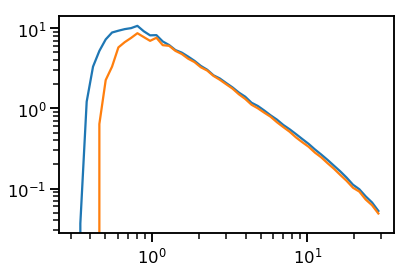

In [40]:
plt.loglog(r_c, test_tpcf, label = 'measured')
plt.loglog(r_c, mock_tpcf, label = 'hod')

(0.8, 1.2)

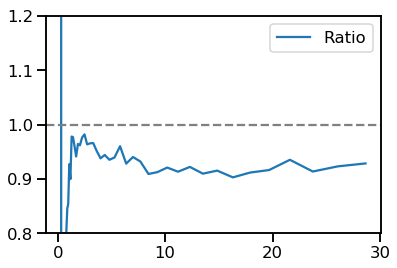

In [41]:
plt.plot(r_c, mock_tpcf/test_tpcf, label = 'Ratio')
plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)

In [42]:
hod_tpcf_dict = {
        'r_c': r_c,
        'tpcf': mock_tpcf,
                }

In [43]:
with open('hod_tpcf.pkl', 'wb') as f:
    pickle.dump(hod_tpcf_dict, f)